# Final Project-- Step Goal Achievement Classification
Author: Zach Frena

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We are going to complete the following workflow: Split data into training and test set. Use the training portion to find the best model using cross validation, then tune the hyperparameters using grid search. Evaluate the *winner* (i.e. the model with the highest accuracy score) on the test set.

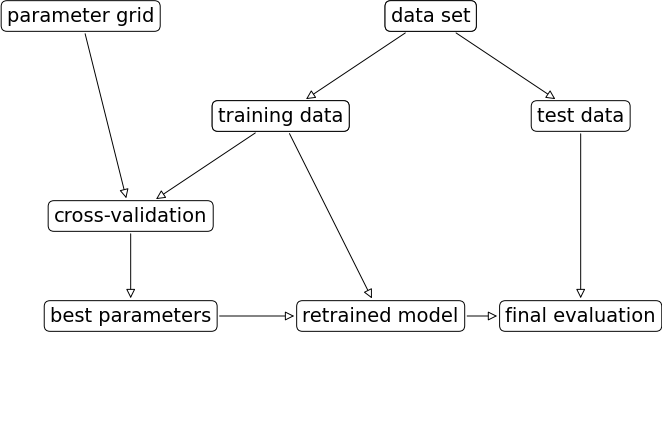

In [3]:
# !pip install mglearn
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions

In [4]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
    #  #TODO: implement function body
    # scores = cross_validate(model, X, y, cv=cv, 
    #                     scoring=scoring,
    #                     return_train_score=True)

    # return ([scores['train_score'].mean(),scores['test_score'].mean()])
    score_list = cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True)
    mean_train_score = score_list['train_score'].mean()
    mean_test_score = score_list['test_score'].mean()
    return mean_train_score, mean_test_score

In [5]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    print(grid_search.best_params_)
    print("Training score = {0:.3f} Validation score = {1:.3f}"
          .format(grid_search.cv_results_['mean_train_score'][np.where(grid_search.cv_results_['mean_test_score'] == grid_search.best_score_)[0][0]],
                  grid_search.best_score_)) # Training score is pulled from the same index as validation score
    

In [6]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    plt.figure(figsize=(20,6))
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="flare", fmt="%0.3f")

In [60]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
 
    #TODO: implement function body
    matrix = confusion_matrix(y_actual, y_pred)
    sns.heatmap(matrix, square=True, annot=True, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', cmap='Greens')
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.title(title)

## 1. Load data

### 1.1 Prepare the feature matrix and target vector

Load the final data set into feature matrix `X` and target vector `y`.
Print shape and type of `X`, `y`.

In [19]:
dataset = pd.read_csv(r"activity_final_dataset.csv")

In [20]:
print(dataset.shape)

(358, 12)


Let's take a look at the first 10 rows of our input data.

We can see that the full dataset contains the Activity Type (description of the activity) along with measured metrics pertaining to that particular event.

In the final column `Goal_Achieved`, we can see whether the step goal was achieved (i.e. steps > 5,700) or not.

In [21]:
dataset.head(10)

,Activity Type,Distance,Calories,Avg HR,Max HR,Aerobic TE,Total Reps,Total Sets,Elapsed Time (hours),Total Calories,Steps,Goal_Achieved
0,Calgary Walking,3.81,245,94,121,0.9,0,0,0.729,3666,11385,1
1,Calgary Hockey,11.93,1049,113,139,2.2,0,0,3.065,3666,11385,1
2,Calgary Walking,5.02,332,92,112,1.1,0,0,1.004,2379,7439,1
3,Strength,0.00,18,88,110,0.1,101,1,0.267,2382,4174,0
4,Strength,0.00,13,86,119,0.2,105,1,0.939,2382,4174,0
5,Strength,0.00,11,87,102,0.1,101,1,0.211,2382,4174,0
6,Calgary Running,3.16,227,151,171,2.9,0,0,0.281,2382,4174,0
7,Calgary Hockey,4.72,507,120,158,2.2,0,0,1.164,2886,3853,0
8,Calgary Hockey,4.78,422,116,156,2.2,0,0,0.976,2886,3853,0
9,Strength,0.00,105,94,121,0.4,301,1,0.810,2732,3514,0




We can plot the distribution of the total calories burned across the entire dataset to get a visual understanding of activity levels.

It appears that ~90% of the days had a total calorie count falling in-between 2000-3500.

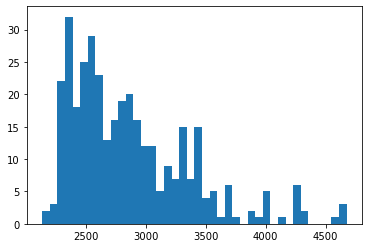

In [22]:
plt.hist(dataset['Total Calories'], bins = 40)
plt.show()

The feature matrix will comprise of everything up to the last column (up to `Goal_Achieved`). We will also drop the total daily steps column (`Steps`), since this is an exercise in classification. 

Side-note: The descrete nature of the `Steps` data may be useful for a regression task in future project. 

In [23]:
feature_matrix = dataset.iloc[:,0:11].drop(['Steps'], axis=1) 
feature_matrix.head() 

,Activity Type,Distance,Calories,Avg HR,Max HR,Aerobic TE,Total Reps,Total Sets,Elapsed Time (hours),Total Calories
0,Calgary Walking,3.81,245,94,121,0.9,0,0,0.729,3666
1,Calgary Hockey,11.93,1049,113,139,2.2,0,0,3.065,3666
2,Calgary Walking,5.02,332,92,112,1.1,0,0,1.004,2379
3,Strength,0.00,18,88,110,0.1,101,1,0.267,2382
4,Strength,0.00,13,86,119,0.2,105,1,0.939,2382


Next, extract the final column of the dataset and equate it as the target vector. The `1`s indicate that the step goal has been achieved, whereas the `0`s indicate that it was not achieved.

In [24]:
target_vector = dataset.iloc[:,-1]
target_vector.head(10)

0    1
1    1
2    1
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: Goal_Achieved, dtype: int64

# 2. How should we approach encoding the non-numerical columns?
We could use a label encoder to transform the Activity Type and Title column data into numerical values, however this may result in ranking based on alphabet. 

We don't want the resulting model to capture a (non-existent) relationship such as `Walking > Hiking > Strength training`, etc. 
For this reason, we will be moving forward with a One-Hot Encoder.


In [25]:
feature_matrix['Activity Type'].describe()

count          358
unique          13
top       Strength
freq            95
Name: Activity Type, dtype: object

In [ ]:
from sklearn.preprocessing import OneHotEncoder
OneHE = OneHotEncoder(sparse=False)
activity_enc = OneHE.fit_transform(feature_matrix[['Activity Type']])
print("The finalized shape of the newly encoded Activity data is: " + str(activity_enc.shape))
feature_names = OneHE.get_feature_names(['Activity'])
print("The Feature Names are: ")
print(feature_names)

The finalized shape of the newly encoded Activity data is: (358, 13)
The Feature Names are: 
['Activity_Calgary Cycling' 'Activity_Calgary Hiking'
 'Activity_Calgary Hockey' 'Activity_Calgary Running'
 'Activity_Calgary Walking' 'Activity_Cardio' 'Activity_Halifax Kayak'
 'Activity_Halifax Walking' 'Activity_Hockey' 'Activity_Pool Swimming'
 'Activity_Strength' 'Activity_Vancouver Cycling'
 'Activity_Vancouver Hiking']


Replace the `Activity_Type` column (non-numerical)in the feature matrix with the newly encoded Activity data (numerical). 

Also, convert any String values into numerical features.

In [27]:
activity_enc = pd.DataFrame(activity_enc, columns=feature_names)
final_feature_matrix = pd.concat([activity_enc,feature_matrix],axis=1).drop(['Activity Type'], axis=1)
final_feature_matrix['Calories'] = final_feature_matrix['Calories'].astype(int)
final_feature_matrix['Aerobic TE'] = final_feature_matrix['Aerobic TE'].astype(int)
final_feature_matrix.head()

,Activity_Calgary Cycling,Activity_Calgary Hiking,Activity_Calgary Hockey,Activity_Calgary Running,Activity_Calgary Walking,Activity_Cardio,Activity_Halifax Kayak,Activity_Halifax Walking,Activity_Hockey,Activity_Pool Swimming,...,Activity_Vancouver Hiking,Distance,Calories,Avg HR,Max HR,Aerobic TE,Total Reps,Total Sets,Elapsed Time (hours),Total Calories
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.81,245,94,121,0,0,0,0.729,3666
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.93,1049,113,139,2,0,0,3.065,3666
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.02,332,92,112,1,0,0,1.004,2379
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,18,88,110,0,101,1,0.267,2382
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,13,86,119,0,105,1,0.939,2382


# 3. Feature Correlation:
I was curious to see what kind of correlation the various features had with eachother (with this many columns, the best way was to create a heatmap!).

An easy way to interpret this graph is to see what parts stand out visually-- values that have a correlation value close to 1 are going to be darkened/bolded on the map.

Comments on several highly-correlated features:
- `Calories` vs. `Elapsed Time` (0.83) -- this makes sense, as longer workouts/activities usually correspond to higher energy usage rates.
- `Aerobic TE (training effect)` vs. `Max HR` (0.77) -- extended periods of cardiovascular exercise (requiring a high average heart-rate) will generally produce higher Aerobic measurement scores.
- `Total Sets` vs. `Total Reps` (0.96) -- Very rarely will a logged activity have a low number of sets while simulateneously having a high number of reps. In addition, reps and sets cannot exist without the presence of one another.

Comments on a few negatively correlated features:
- `Total Sets` vs. `Avg HR` (-0.21) -- An exercise having a `Total Sets` measurement is likely to be a strength workout, and therefore the average heart rate will likely be much lower than a cardiovascular exercise like a run or hike.
- `Total Reps` vs. `Aerobic TE (training effect)` (-0.27) -- Reps and Sets are indicative of weight lifting or strength training, both of which are examples of anaerobic exercises comprising of short bursts of instense movement.

Outside of curiosity, this heat-map is also a useful tool to determine whether the correlation between variables is TOO high. When a model is trained in highly correlated data, it can be severely affected by a problem called `multicollinearity`. It can become difficult to estimate the relationship between each independent variable and the dependent variable because the independent variables tend to change in unison. 

<AxesSubplot:>

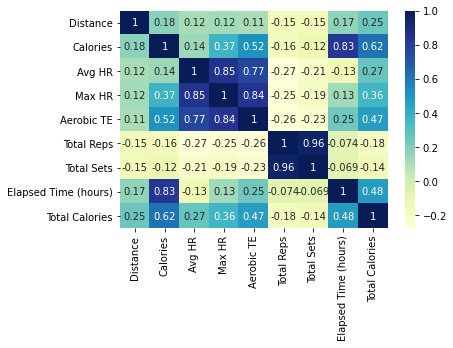

In [28]:
feature_corr = final_feature_matrix.iloc[:,13:].corr() # only using the non-encoded data (i.e. left out Activity_Type)
sns.heatmap(feature_corr, annot=True, cmap="YlGnBu") 

## 4. Create training and test sets
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, we will split our feature and target matrixes into training and test sets.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_feature_matrix, target_vector, 
                                                    test_size=0.2,
                                                    random_state=37) #split data into 2 sets-- 1 for training and 1 for testing
print("The shape of training data (80% of original dataset): ")
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("\nThe shape of testing data (20% of original dataset): ")
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

The shape of training data (80% of original dataset): 
X_train:  (286, 22)
y_train:  (286,)

The shape of testing data (20% of original dataset): 
X_test:  (72, 22)
y_test:  (72,)


## 5. Which machine learning model should we use?
### Let's compare some models using cross-validation!
We will be evaluating the following models: `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier()`, 
         `GradientBoostingClassifier()`.

Using the training data and 7-fold cross validation, we will iterate this list of models, then:
- compute the **average precision** using `get_classifier_cv_score()` defined above, 
- rank the models based on validation **average precision** (best first)

In [44]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB as B
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
model_List = [LR(solver='lbfgs', max_iter=10000), SVC(), B(), RFC(), GBC()]
unsortedList = []
for model in model_List:
    scores = get_classifier_cv_score(model, X_train, y_train, scoring='average_precision', cv=7)
    unsortedList.append((type(model).__name__, scores))

unsortedList.sort(key= lambda x: x[1][1], reverse=True)
adjectiveList=['*Best*','*Second best*','*Third best*', '*Second worst*','*Worst*']
for i in range(0,5):
    print('{} average precision--> {} (training score: {:.3f}, testing score: {:.3f})'
    .format(adjectiveList[i], unsortedList[i][0], unsortedList[i][1][0], unsortedList[i][1][1]))

*Best* average precision--> GradientBoostingClassifier (training score: 0.999, testing score: 0.840)
*Second best* average precision--> RandomForestClassifier (training score: 1.000, testing score: 0.838)
*Third best* average precision--> LogisticRegression (training score: 0.868, testing score: 0.825)
*Second worst* average precision--> SVC (training score: 0.723, testing score: 0.714)
*Worst* average precision--> BernoulliNB (training score: 0.710, testing score: 0.689)


## 6. Hyperparameter tuning using grid search 

The inital cross-validation above showed that both DecisionTree based models (`Gradient Boosting` and `Random Forest`) might have merit. 

Logistic Regression might also perform well if properly tuned.

Next, hyperparameters are tuned using grid search.

### 6.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier()`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Hyperparameters and values:
- `'n_estimators': [300, 500, 700, 1000]`
- `'max_depth': [7, 9, 11, 13]`

We will use the `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [31]:
from sklearn.model_selection import GridSearchCV
grid_search_cv_RF = GridSearchCV(estimator=RFC(),
                                 param_grid={'n_estimators': [300, 500, 700, 1000],
                                             'max_depth': [7, 9, 11, 13]},
                                 scoring='average_precision',
                                 n_jobs=-1,
                                 cv=7,
                                 return_train_score=True)

In [32]:
# perform the grid search by calling fit(), then call print_grid_search_result() to print the results
grid_search_cv_RF.fit(X_train, y_train)
print_grid_search_result(grid_search_cv_RF)

{'max_depth': 7, 'n_estimators': 700}
Training score = 0.998 Validation score = 0.849


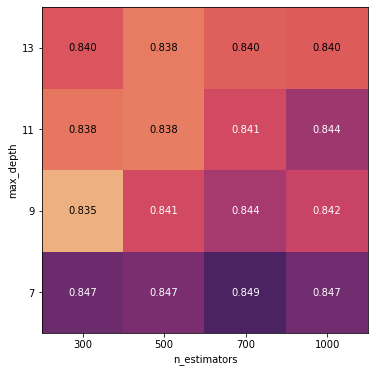

In [33]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_search_cv_RF)

### 6.2 Gradient boosting classifier 
Perform grid search using `GridSearchCV` for the `GradientBoostingClassifier(max_depth=5)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Hyperparameters and values:
- `'n_estimators': [50, 100, 200]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`

As before, we will use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [34]:
# Setup grid search for GradientBoostingClassifier(max_depth=5)
grid_search_cv_GB = GridSearchCV(estimator=GBC(max_depth=5),
                                 param_grid={'n_estimators': [50, 100, 200],
                                             'learning_rate': [0.001, 0.01, 0.1, 1.0]},
                                 scoring='average_precision',
                                 n_jobs=-1,
                                 cv=7,
                                 return_train_score=True)

In [45]:
# perform the grid search by calling fit(), then call print_grid_search_result() to print the results
grid_search_cv_GB.fit(X_train, y_train)
print_grid_search_result(grid_search_cv_GB)

{'learning_rate': 0.1, 'n_estimators': 100}
Training score = 1.000 Validation score = 0.831


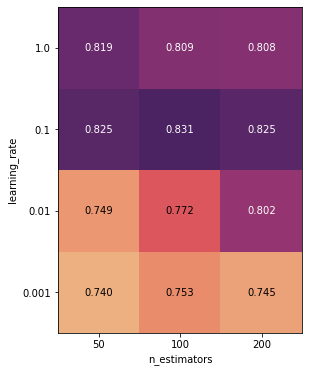

In [36]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_search_cv_GB)

### 6.3 Logistic Regression grid search
Perform grid search using `GridSearchCV` for the `LogisticRegression()`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Hyperparameters and values:
- `'C': numpy.logspace(-3,3,7)` --- these values were taken from https://www.kaggle.com/enespolat/grid-search-with-logistic-regression, but essentially it's a log scale.
- `'class_weight':["None","balanced"]`

Same as before, we will use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [37]:
# Setup grid search for LogisticRegression()
grid_search_cv_LR = GridSearchCV(estimator=LR(max_iter=10000),
                                 param_grid={'C' : np.logspace(-3,3,7),
                                            'class_weight' : ['None', 'balanced']},
                                 scoring='average_precision',
                                 n_jobs=-1,
                                 cv=7,
                                 return_train_score=True)

In [38]:
# perform the grid search by calling fit(), then call print_grid_search_result() to print the results
grid_search_cv_LR.fit(X_train, y_train)
print_grid_search_result(grid_search_cv_LR)

{'C': 10.0, 'class_weight': 'None'}
Training score = 0.876 Validation score = 0.831


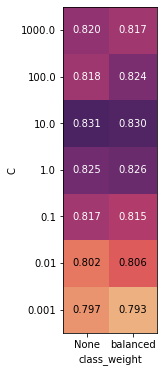

In [39]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_search_cv_LR)

### Summary: the training and validation scores of the three tuned (best) models:

Best `random forest` classifier model:

- Training score = 0.998 
- Validation score = 0.852


Best `gradient boosting` classifier model:

- Training score = 1.000 
- Validation score = 0.831


Best `logistic regression` classifier model:

- Training score = 0.876 
- Validation score = 0.831

## 7. Discussion: Which model is the "best"?

At first glance, it appears that our tuned `random forest model` is the best as it has the highest validation score (0.852). However, take a look at the training score (0.998), yikes! This indicates that our model is likely overfitting the data, which is not ideal. 

We are looking for a model with a good degree of flexibility, but not to the point where every single training point is accounted for. Due to noise and other common variances within the data, we want to generalize trends without overfitting (or underfitting).

The `logistic regression` model is exactly what we are looking for: a validation score (0.831) that is reasonable with a training score (0.876) that doesn't indicate overfitting.

## 8. Let's retrain our best model (Logistic Regression)!
Retrain the best `Logistic Regressor` model using the tuned hyperparameters from grid search above on the training dataset.


In [46]:
BestModel_LR = LR(C= 1000.0, class_weight= 'balanced', max_iter=10000)
BestModel_LR.fit(X_train, y_train)

LogisticRegression(C=1000.0, class_weight='balanced', max_iter=10000)

In [47]:
from sklearn.metrics import classification_report

y_pred = BestModel_LR.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80        43
           1       0.70      0.66      0.68        29

    accuracy                           0.75        72
   macro avg       0.74      0.73      0.74        72
weighted avg       0.75      0.75      0.75        72



### Printing out confusion matrix:

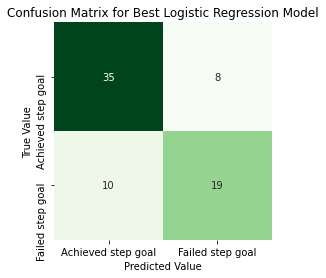

In [61]:
plot_confusion_matrix(y_test, y_pred, labels=['Achieved step goal','Failed step goal'], title="Confusion Matrix for Best Logistic Regression Model")

## Discussion of Confusion Matrix:
In my opinion, this is a very decent result for the relatively small amount of data provided to the model. Being able to predict a correct label 75% of the time is impressive, especially considering that a human looking at this data would have a 50% success rate by randomly guessing. 

In this scenario there is little real-world penalty when it comes to false negatives or false positives-- it is simply a wrong classification. One could argue that if you want to achieve your step goals, a `false negative` (i.e. predicting that you failed your goal when you actually achieved it) would make you sad and un-motivated to continue (*"Why am I even trying? I should just quit-- I work so hard and still can't achieve my goals!"*). On the other hand, a `false positive` (i.e. predicting that you achieved your goal when you actually failed it) would instill a false sense of confidence in yourself and potentially decrease your fitness levels (*"Wow I'm doing great, I earned the right to be unhealthy for a bit!"*).

# 9. Relative importance of features:
Determining which features have a high/low impact on the predicted result is beneficial for many reasons. For example, we can optimize variable selection — you can remove certain variables that are not overly significant and have still hopefully achieve similar (or better) performance in much shorter training time.

Another major benefit is that we now have an idea on how to modify future behaviour to impact the dependant variables. Let's say that we really wanted to achieve more step goals (log more than 5,700 steps)-- we can increase the frequency of more important features, and decrease the frequency of the less important features.


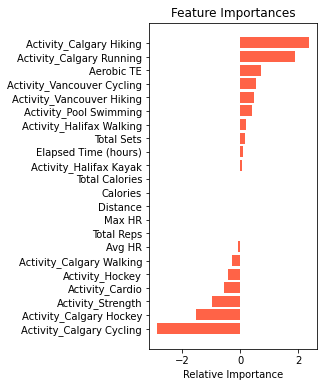

In [62]:
features = [col for col in final_feature_matrix.columns]
importances = BestModel_LR.coef_[0]
indices = np.argsort(importances) # method inspired by http://www.agcross.com/2015/02/random-forests-scikit-learn/
plt.figure(figsize=(3,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='tomato', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Discussion of Feature Importance:
Having an interpretable model such as this one really helps uncover insights about WHY certain features are impactful. 
As seen in the chart above, the features with the highest (relative) importance are: `Calgary Hiking`, `Vancouver Cycling`, `Pool Swimming`, `Vancouver Hiking`, and `Calgary Running`.

Personal thoughts/reasoning for *high importance*:
- `Calgary Hiking` and `Vancouver Hiking` -- Hiking requires lots of steps! Even a relatively average 10km hike will demand 15,000-20,000 steps.
- `Vancouver Cycling` -- This seems counter-intuitive at first (`Calgary Cycling` has the lowest relative importance!), however since Vancouver is a vacation destination I walked more on a daily basis. In addition, this seems like an instance where minimal samples injected a high amount of bias when training my model.
- `Pool Swimming` -- Easily explainable by the fact that I always walked to the pool facility instead of driving or biking.
- `Calgary Running` -- more running == more steps!


The features with the lowest (relative) importance are: `Calgary Cycling`, `Strength`, `Hockey`, and `Cardio`.

Personal thoughts/reasoning for the *low (negative) importance*:
 - `Calgary Cycling` -- Less steps were being taken on days when I rode my bike in Calgary.
 - `Strength` -- Weight training and strength exercises usually consisted of stationary movements with few steps being taken.
 - `Hockey` -- The watch is intelligent enough to know the difference between skating and walking, and whenever I had a hockey game scheduled I would usually be discouraged from going on walks, runs, etc.
 - `Cardio` -- Cardio usually referred to activities like stationary biking, skipping rope, etc. (i.e. requiring minimal steps)
